# Bgee

Extracting data from [Bgee](http://bgee.unil.ch/). See [this Thinklab discussion](http://thinklab.com/discussion/tissue-specific-gene-expression-resources/81#278) for more information.

In [1]:
import collections

import pandas
import seaborn
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [2]:
def get_groupby_counts(df, columns):
    """Group datagrame by columns and return the number of rows for each grouping."""
    grouped = df.groupby(columns)
    get_len = lambda df: pandas.Series({'count': len(df)})
    df = grouped.apply(get_len)
    df = df.sort('count', ascending=False)
    df = df.reset_index()
    return df

## Read and process presence of expression data

In [3]:
# Read expression
presence_df = pandas.read_table('download/Homo_sapiens_expr-simple.tsv.gz', compression='gzip')
presence_df.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,HsapDv:0000092,human middle aged stage (human),present,poor quality
1,ENSG00000000003,TSPAN6,CL:0000019,sperm,HsapDv:0000088,human early adulthood stage (human),present,poor quality
2,ENSG00000000003,TSPAN6,CL:0000023,oocyte,HsapDv:0000087,human adult stage (human),absent,high quality
3,ENSG00000000003,TSPAN6,CL:0000083,epithelial cell of pancreas,UBERON:0000104,life cycle,present,high quality
4,ENSG00000000003,TSPAN6,CL:0000115,endothelial cell,HsapDv:0000092,human middle aged stage (human),present,poor quality


In [4]:
# Apply filters for gene presence
present_df = presence_df[
    presence_df['Call quality'].isin({'high quality', 'low quality'}) &
    presence_df['Expression'].isin({'present', 'low ambiguity'})
]

In [5]:
# Find genes present per developmental stage
stage_df = get_groupby_counts(present_df, ['Developmental stage ID', 'Developmental stage name'])
stage_df.head(12)

,Developmental stage ID,Developmental stage name,count
0,HsapDv:0000090,25-44 year-old human stage (human),886385
1,UBERON:0000104,life cycle,795802
2,HsapDv:0000092,human middle aged stage (human),767581
3,HsapDv:0000094,65-79 year-old human stage (human),407378
4,HsapDv:0000087,human adult stage (human),387225
5,HsapDv:0000089,young adult stage (human),383819
6,HsapDv:0000095,80 year-old and over human stage (human),160763
7,HsapDv:0000086,adolescent stage (human),116353
8,HsapDv:0000085,6-12 year-old child stage (human),75387
9,HsapDv:0000199,fifth LMP month human stage (human),74310


In [6]:
# Find genes present per anatomical entity
anatomy_df = get_groupby_counts(present_df, ['Anatomical entity ID', 'Anatomical entity name'])
anatomy_df.head(10)

,Anatomical entity ID,Anatomical entity name,count
0,UBERON:0000473,testis,144453
1,UBERON:0000955,brain,114977
2,UBERON:0001870,frontal cortex,110212
3,UBERON:0000178,blood,104919
4,UBERON:0002107,liver,97331
5,UBERON:0002037,cerebellum,92622
6,UBERON:0000992,female gonad,88936
7,UBERON:0001987,placenta,83013
8,UBERON:0009834,dorsolateral prefrontal cortex,82020
9,UBERON:0002048,lung,70698


### Figure 1: Number of genes present by developmental stage and anatomical entity

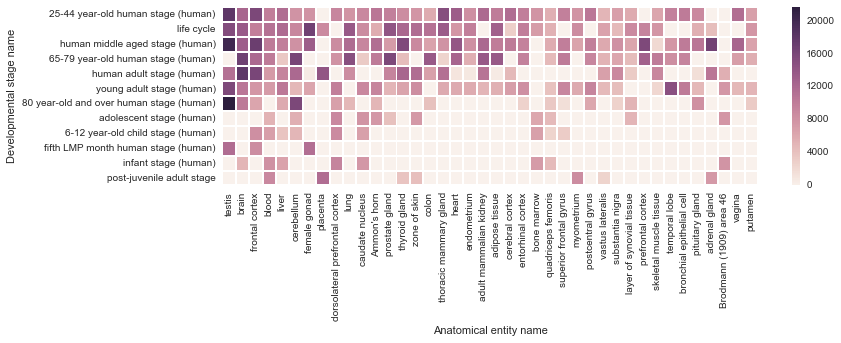

In [7]:
# Number of present genes per development stage -- anatomical entity pair
pairwise_df = get_groupby_counts(present_df, ['Developmental stage name', 'Anatomical entity name'])
rect_df = pairwise_df.pivot('Developmental stage name', 'Anatomical entity name', 'count').fillna(0)
rect_df = rect_df.loc[stage_df['Developmental stage name'][:12], anatomy_df['Anatomical entity name'][:40]]
IPython.core.pylabtools.figsize(12, 3.2)
seaborn.heatmap(rect_df);

## Read and process differential expression data

In [8]:
# Read simple differential expression by anatomy
diffex_df = pandas.read_table('download/Homo_sapiens_diffexpr-anatomy-simple.tsv.gz', compression='gzip')
diffex_df.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Differential expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,UBERON:0000113,post-juvenile adult stage,over-expression,low quality
1,ENSG00000000003,TSPAN6,CL:0000738,leukocyte,UBERON:0000113,post-juvenile adult stage,under-expression,high quality
2,ENSG00000000003,TSPAN6,UBERON:0000002,uterine cervix,UBERON:0000113,post-juvenile adult stage,over-expression,high quality
3,ENSG00000000003,TSPAN6,UBERON:0000007,pituitary gland,UBERON:0000113,post-juvenile adult stage,over-expression,high quality
4,ENSG00000000003,TSPAN6,UBERON:0000029,lymph node,UBERON:0000113,post-juvenile adult stage,under-expression,high quality


In [9]:
# filter differential expression
diffex_df = diffex_df[
    diffex_df['Differential expression'].isin({'over-expression', 'under-expression'}) &
    diffex_df['Call quality'].isin({'Call quality', 'high quality'})
]

In [10]:
# Calculate counts per anatomy--DE pair
de_anatomy_df = get_groupby_counts(diffex_df, ['Anatomical entity ID', 'Anatomical entity name', 'Differential expression'])
de_anatomy_df.head()

,Anatomical entity ID,Anatomical entity name,Differential expression,count
0,CL:0000738,leukocyte,under-expression,10705
1,UBERON:0002369,adrenal gland,over-expression,7749
2,UBERON:0000473,testis,over-expression,7323
3,CL:0000738,leukocyte,over-expression,6563
4,UBERON:0002369,adrenal gland,under-expression,6370


In [11]:
### Figure 2: Number of differntially expressed genes present by anatomical entity

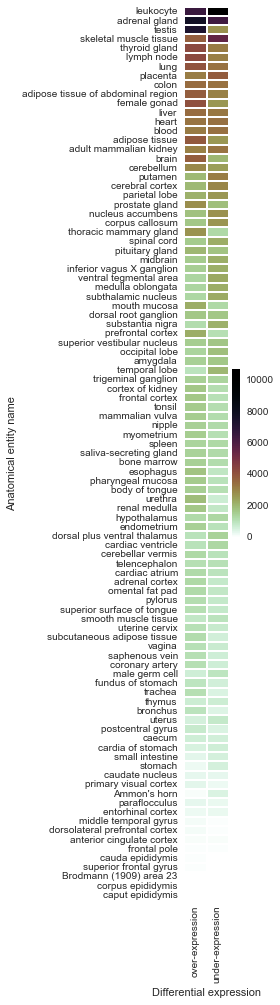

In [12]:
# Plot DE counts
rect_df = de_anatomy_df.pivot('Anatomical entity name', 'Differential expression', 'count').fillna(0)
rect_df['differential expression'] = rect_df['under-expression'] + rect_df['over-expression']
rect_df = rect_df.sort('differential expression', ascending=False)
IPython.core.pylabtools.figsize(1, 16)
cmap = seaborn.cubehelix_palette(15, start=2.2, rot=1, gamma=2, hue=1, light=1, dark=0, as_cmap=True)
seaborn.heatmap(rect_df.drop('differential expression', axis=1), cmap=cmap);

## Conversion from ensembl to entrez gene

Not yet implemented

In [13]:
# Read Entrez Genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']
entrez_map_df = entrez_map_df[['GeneID', 'identifier']].rename(columns={'identifier': 'ensembl_id'})
entrez_map_df.head()

,GeneID,ensembl_id
2,1,ENSG00000121410
7,2,ENSG00000175899
11,3,ENSG00000256069
14,9,ENSG00000171428
19,10,ENSG00000156006


## GNF Expression Atlas (BodyMap) expression counts

Show the presence counts per tissue we observed in the [GNF Expression Atlas](https://dx.doi.org/10.1073/pnas.0400782101) data.

In [14]:
import gzip
import io
import requests
import numpy

# Read BTO id and names
url = 'https://gist.githubusercontent.com/dhimmel/1f252b674c0c75443cc1/raw/a97c3425792f2288b0369de70e1b46018832455b/bto-terms-in-gnf.tsv'
bto_df = pandas.read_table(url)

# Read expression
url = 'http://het.io/disease-genes/downloads/files/expression.txt.gz'
with gzip.open(io.BytesIO(requests.get(url).content)) as read_file:
    gnf_df = pandas.read_table(read_file)
gnf_df = numpy.log10(gnf_df)

In [15]:
# Compute expressed genes per tissue
gnf_summary_df = (gnf_df >= 1.4).sum().reset_index()
gnf_summary_df.columns = ['bto_id', 'count']
gnf_summary_df = bto_df.merge(gnf_summary_df, how='right')
gnf_summary_df = gnf_summary_df.sort('count', ascending=False)
gnf_summary_df.head(15)

,bto_id,bto_name,cell_line,count
72,BTO:0003335,EBV-LCL cell,1,5138
19,BTO:0000725,hematopoietic stem cell,0,4996
28,BTO:0000914,natural killer cell,0,4883
75,BTO:0004730,myeloid progenitor cell,0,4823
36,BTO:0001067,pineal gland,0,4799
65,BTO:0002042,dendritic cell,0,4782
43,BTO:0001175,retina,0,4631
70,BTO:0002807,prefrontal cortex,0,4566
58,BTO:0001379,thyroid gland,0,4534
24,BTO:0000776,B-lymphocyte,0,4415


### Figure 3: Distibution of genes present per tissue in GNF Expression Atlas

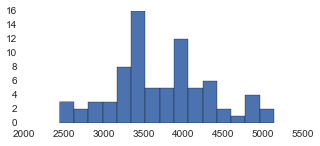

In [16]:
# Plot distribution of expressed genes per tissue
IPython.core.pylabtools.figsize(5, 2)
plt.hist(gnf_summary_df['count'], 15);